import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

bucket = 'adm-project'# enter your s3 bucket where you will copy data and model artifacts
prefix = 'sagemaker/DEMO-carprice-prediction' # place to upload training files within the bucket

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
#import sagemaker.amazon.common as smac

In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import TransformerMixin
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

In [3]:
#bucket='adm-project'
#data_key = 'Data/Car_sales.csv'
#data_location = 's3://{}/{}'.format(bucket, data_key)
data = pd.read_csv(r'C:\Users\prith\Desktop\ADM\Project\Car_sales.csv')

In [4]:
data

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Volvo,V40,3.545,NaN,Passenger,24.40,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,9/21/2011,66.498812
153,Volvo,S70,15.245,NaN,Passenger,27.50,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,11/24/2012,70.654495
154,Volvo,V70,17.531,NaN,Passenger,28.80,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,6/25/2011,71.155978
155,Volvo,C70,3.493,NaN,Passenger,45.50,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,4/26/2011,101.623357


In [5]:
data.values

array([['Acura', 'Integra', 16.919, ..., 28.0, '2/2/2012', 58.28014952],
       ['Acura', 'TL', 39.384, ..., 25.0, '6/3/2011', 91.37077766],
       ['Acura', 'CL', 14.114, ..., 26.0, '1/4/2012', nan],
       ...,
       ['Volvo', 'V70', 17.531, ..., 25.0, '6/25/2011', 71.1559776],
       ['Volvo', 'C70', 3.4930000000000003, ..., 23.0, '4/26/2011',
        101.6233572],
       ['Volvo', 'S80', 18.969, ..., 24.0, '11/14/2011', 85.73565451]],
      dtype=object)

In [6]:
data.columns

Index(['Manufacturer', 'Model', 'Sales_in_thousands', '__year_resale_value',
       'Vehicle_type', 'Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency', 'Latest_Launch', 'Power_perf_factor'],
      dtype='object')

In [7]:
data.describe()

,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.000000,121.000000,155.000000,156.000000,156.000000,156.000000,156.000000,156.000000,155.000000,156.000000,154.000000,155.000000
mean,52.998076,18.072975,27.390755,3.060897,185.948718,107.487179,71.150000,187.343590,3.378026,17.951923,23.844156,77.043591
std,68.029422,11.453384,14.351653,1.044653,56.700321,7.641303,3.451872,13.431754,0.630502,3.887921,4.282706,25.142664
min,0.110000,5.160000,9.235000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,23.276272
25%,14.114000,11.260000,18.017500,2.300000,149.500000,103.000000,68.400000,177.575000,2.971000,15.800000,21.000000,60.407707
50%,29.450000,14.180000,22.799000,3.000000,177.500000,107.000000,70.550000,187.900000,3.342000,17.200000,24.000000,72.030917
75%,67.956000,19.875000,31.947500,3.575000,215.000000,112.200000,73.425000,196.125000,3.799500,19.575000,26.000000,89.414878
max,540.561000,67.550000,85.500000,8.000000,450.000000,138.700000,79.900000,224.500000,5.572000,32.000000,45.000000,188.144323


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
Manufacturer           157 non-null object
Model                  157 non-null object
Sales_in_thousands     157 non-null float64
__year_resale_value    121 non-null float64
Vehicle_type           157 non-null object
Price_in_thousands     155 non-null float64
Engine_size            156 non-null float64
Horsepower             156 non-null float64
Wheelbase              156 non-null float64
Width                  156 non-null float64
Length                 156 non-null float64
Curb_weight            155 non-null float64
Fuel_capacity          156 non-null float64
Fuel_efficiency        154 non-null float64
Latest_Launch          157 non-null object
Power_perf_factor      155 non-null float64
dtypes: float64(12), object(4)
memory usage: 19.8+ KB


In [9]:
data.isnull().sum()

Manufacturer            0
Model                   0
Sales_in_thousands      0
__year_resale_value    36
Vehicle_type            0
Price_in_thousands      2
Engine_size             1
Horsepower              1
Wheelbase               1
Width                   1
Length                  1
Curb_weight             2
Fuel_capacity           1
Fuel_efficiency         3
Latest_Launch           0
Power_perf_factor       2
dtype: int64

In [10]:
df = data.fillna(data.mean())
df2 = data.fillna(data.mean())

In [61]:
df = df.append(df2, ignore_index=True)

In [62]:
df.isnull().sum()

Manufacturer           0
Model                  0
Sales_in_thousands     0
__year_resale_value    0
Vehicle_type           0
Price_in_thousands     0
Engine_size            0
Horsepower             0
Wheelbase              0
Width                  0
Length                 0
Curb_weight            0
Fuel_capacity          0
Fuel_efficiency        0
Latest_Launch          0
Power_perf_factor      0
dtype: int64

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8007 entries, 0 to 8006
Data columns (total 16 columns):
Manufacturer           8007 non-null object
Model                  8007 non-null object
Sales_in_thousands     8007 non-null float64
__year_resale_value    8007 non-null float64
Vehicle_type           8007 non-null object
Price_in_thousands     8007 non-null float64
Engine_size            8007 non-null float64
Horsepower             8007 non-null float64
Wheelbase              8007 non-null float64
Width                  8007 non-null float64
Length                 8007 non-null float64
Curb_weight            8007 non-null float64
Fuel_capacity          8007 non-null float64
Fuel_efficiency        8007 non-null float64
Latest_Launch          8007 non-null object
Power_perf_factor      8007 non-null float64
dtypes: float64(12), object(4)
memory usage: 1001.0+ KB


In [64]:
df['Latest_Launch']=pd.to_datetime(df['Latest_Launch'])

(8007, 16)

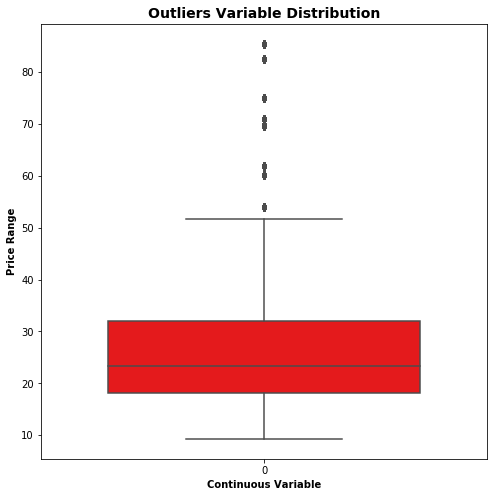

In [65]:
#Checking for outliers in the dependent variable
#outliers = ['price']
plt.rcParams['figure.figsize'] = [8,8]
sns.boxplot(data=df['Price_in_thousands'], orient="v", palette="Set1" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Price Range", fontweight = 'bold')
plt.xlabel("Continuous Variable", fontweight = 'bold')
df.shape

#### We can see that there are some car models whose price is greater than 50k. We won't remove them instead we will use standardized scaling.

In [66]:
#Checking for duplicate values in the dataframe
df.loc[df.duplicated()]

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
157,Acura,Integra,16.919,16.360000,Passenger,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2012-02-02,58.280150
158,Acura,TL,39.384,19.875000,Passenger,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,2011-06-03,91.370778
159,Acura,CL,14.114,18.225000,Passenger,27.390755,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,2012-01-04,77.043591
160,Acura,RL,8.588,29.725000,Passenger,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2011-03-10,91.389779
161,Audi,A4,20.397,22.255000,Passenger,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,2011-10-08,62.777639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8002,Volvo,V40,3.545,18.072975,Passenger,24.400000,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,2011-09-21,66.498812
8003,Volvo,S70,15.245,18.072975,Passenger,27.500000,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,2012-11-24,70.654495
8004,Volvo,V70,17.531,18.072975,Passenger,28.800000,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,2011-06-25,71.155978
8005,Volvo,C70,3.493,18.072975,Passenger,45.500000,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,2011-04-26,101.623357


#### Now let us segregate between the categorical and numerical columns

In [67]:
cate_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['datetime','object']).columns
df_cat = df[cate_cols]
df_num = df[num_cols]

## Visualizing the data

Text(0, 0.5, 'Count of Cars')

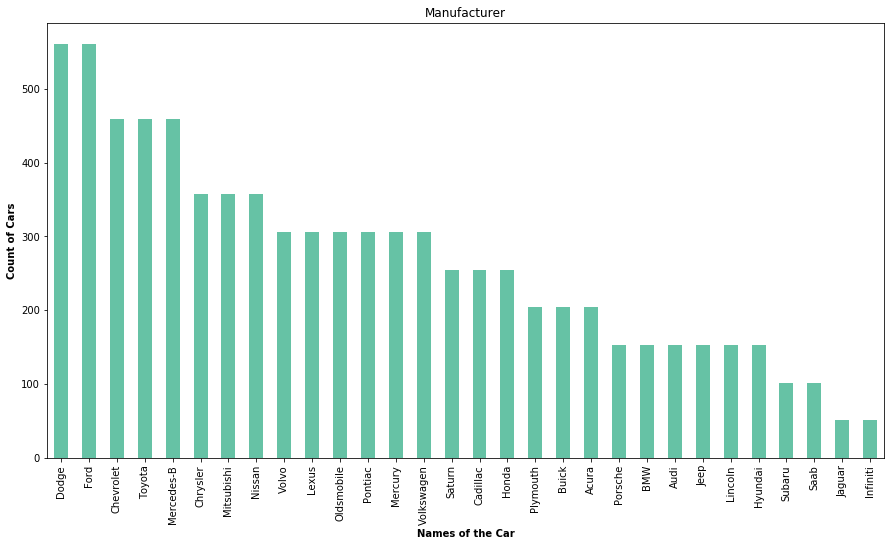

In [68]:
plt.rcParams['figure.figsize'] = [15,8]
ax=df['Manufacturer'].value_counts().plot(kind='bar',stacked=True, colormap = 'Set2')
ax.title.set_text('Manufacturer')
plt.xlabel("Names of the Car",fontweight = 'bold')
plt.ylabel("Count of Cars",fontweight = 'bold')

### Manufacturers Ford and Dodge seemed to have sold the most cars in our dataset whereas Jaguar and Infiniti seem to have sold the least number of cars

#### Now, let's see the distribution of the price range 

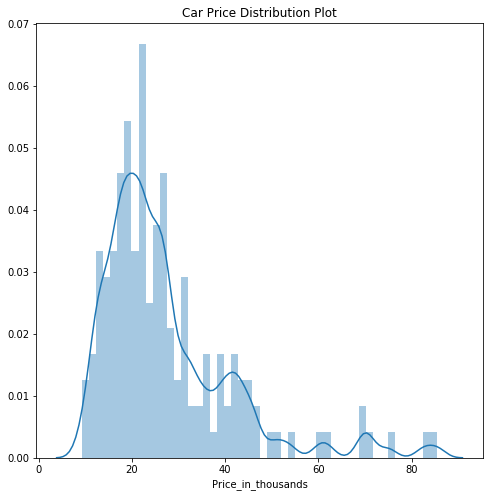

In [69]:
plt.figure(figsize=(8,8))

plt.title('Car Price Distribution Plot')
sns.distplot(df['Price_in_thousands'])

#### The graph seems to be right skewed, most of the cars are priced in the range 20k-40k with a few exceptions.

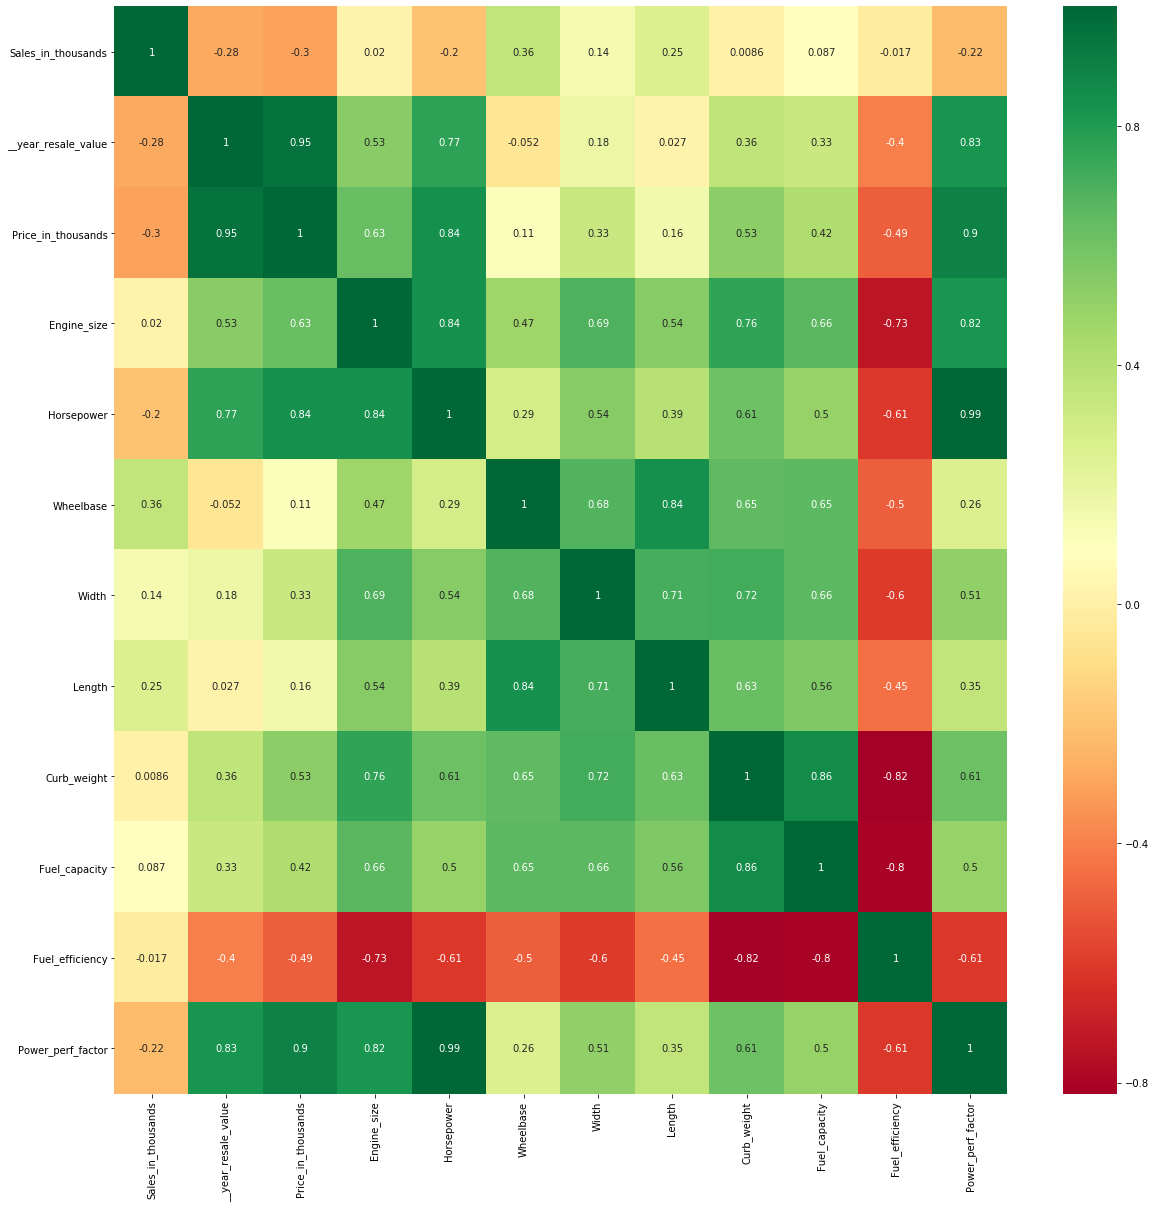

In [70]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (20, 20))
sns.heatmap(data.corr(), cmap="RdYlGn", annot=True)
plt.show()

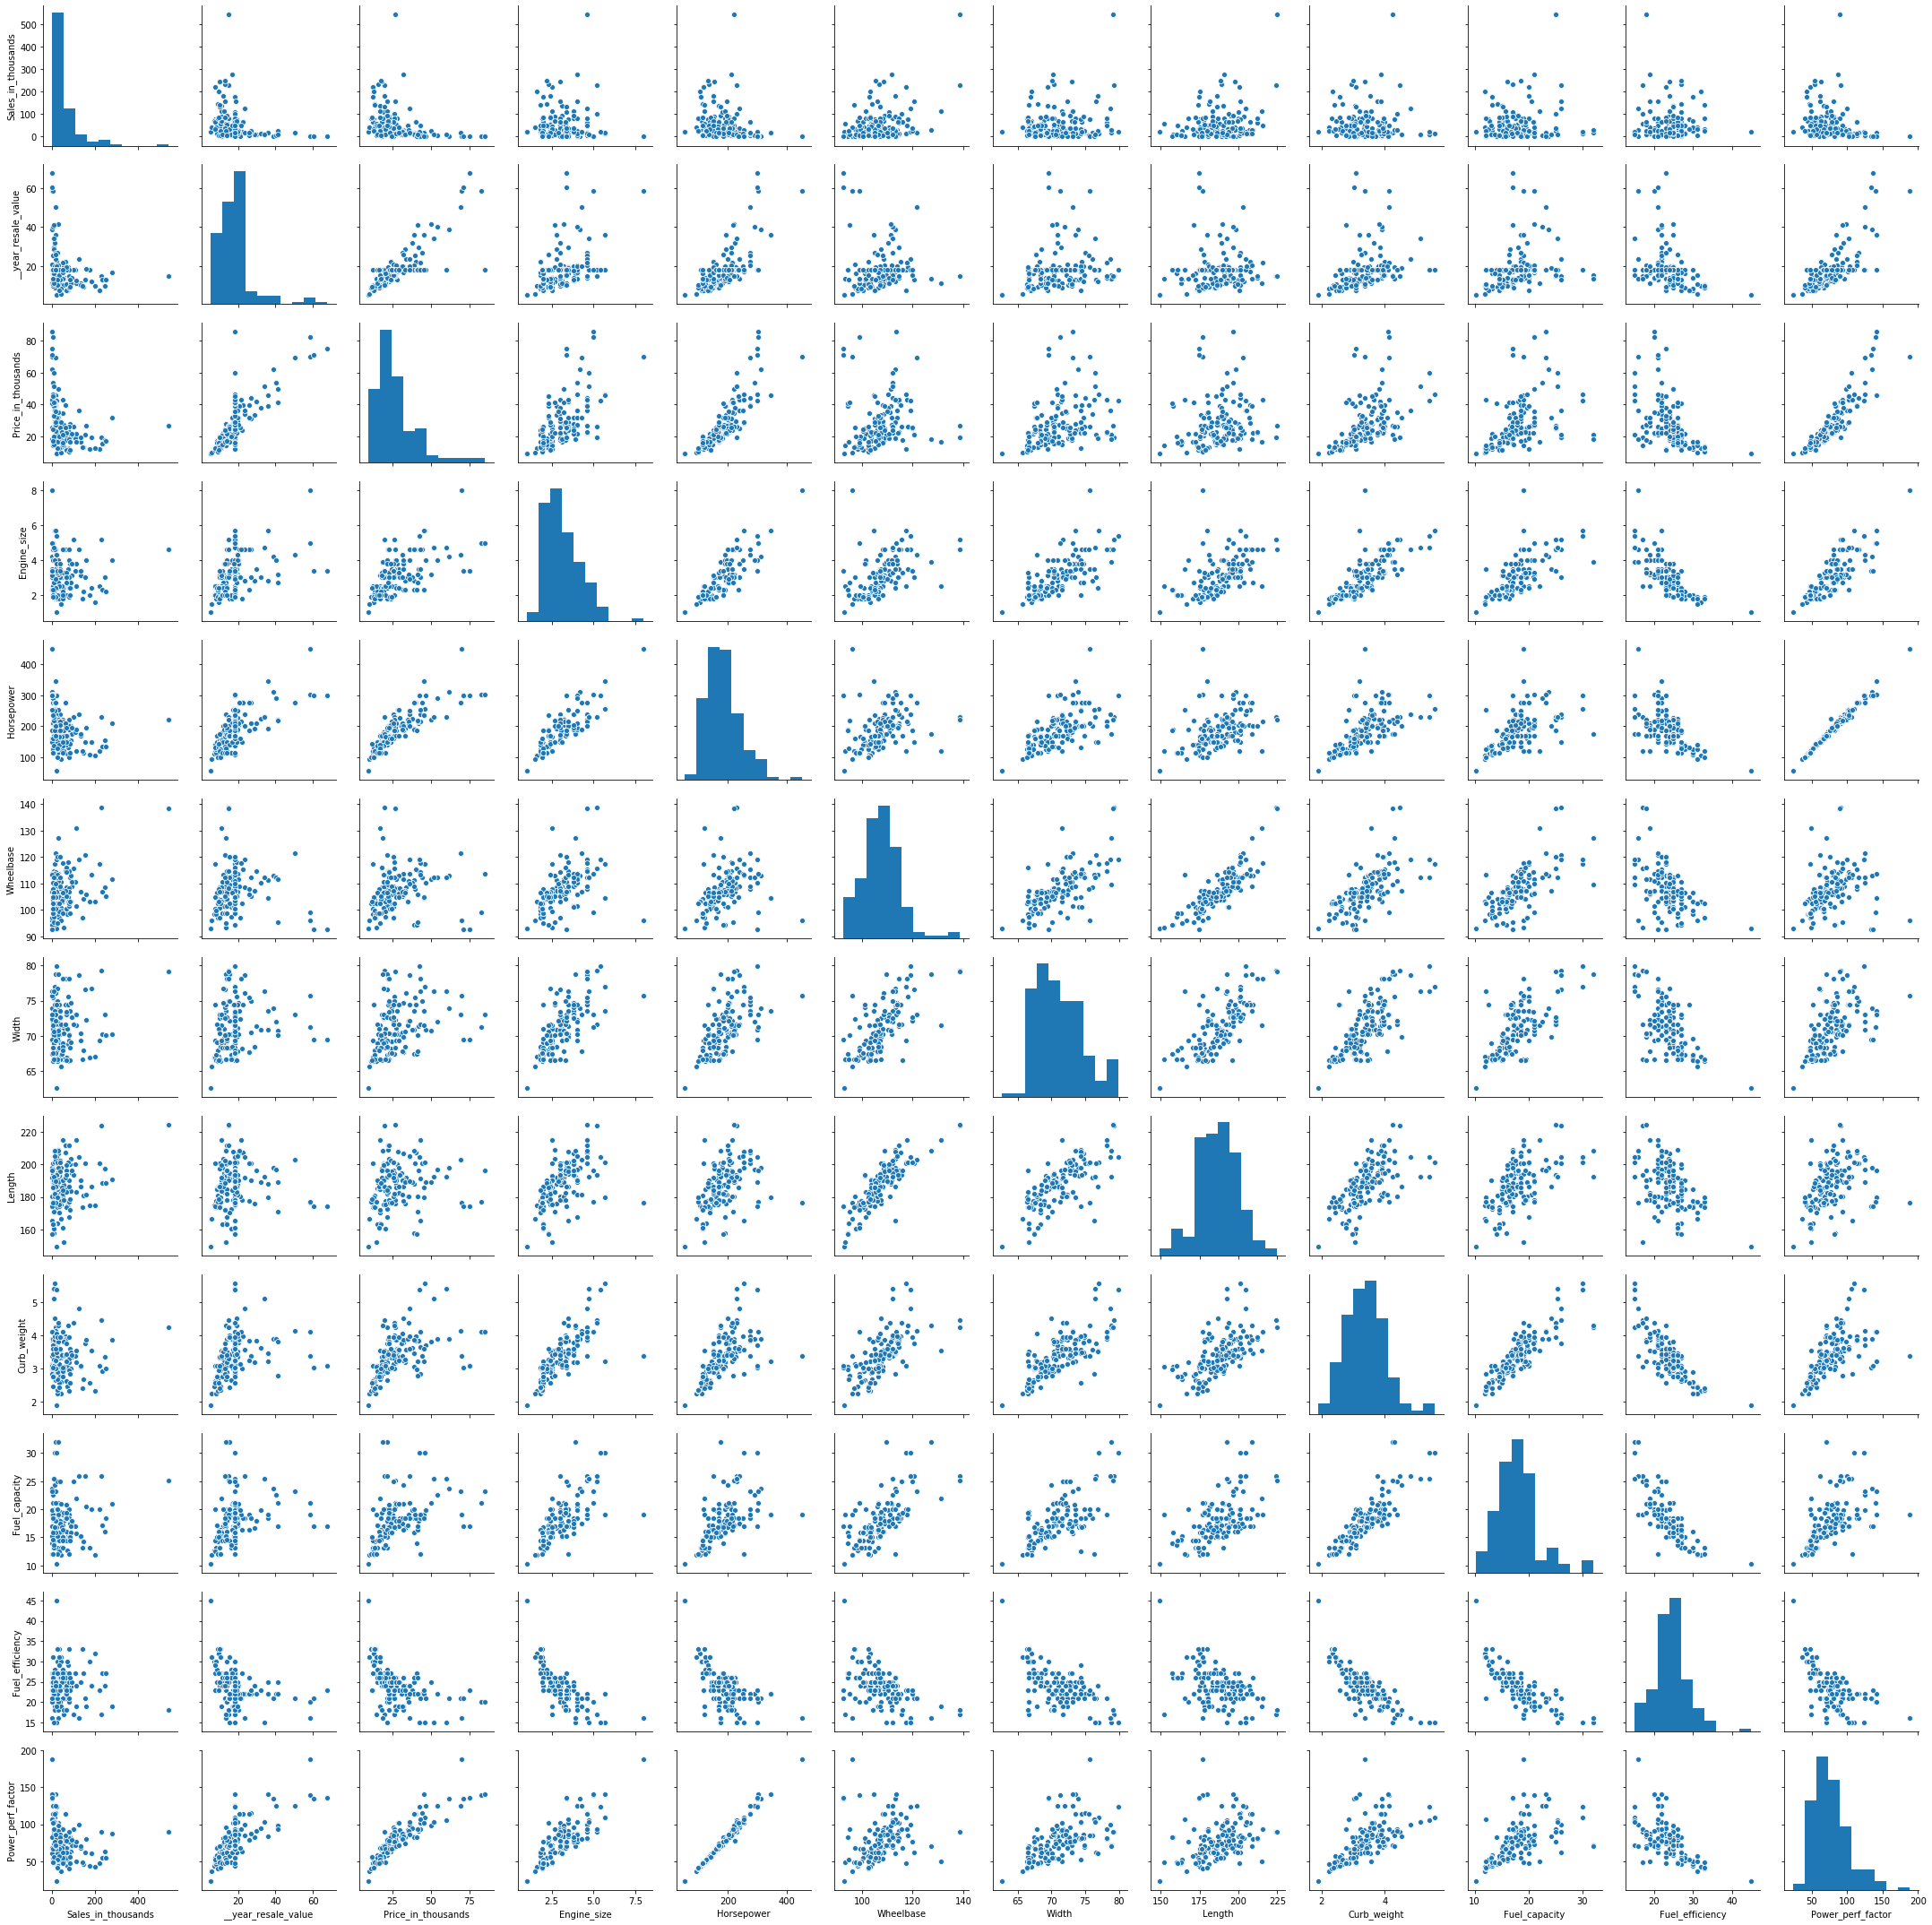

In [71]:
#checking correlation between variables
sns.pairplot(df[num_cols])

Power_perf_factor, curb_weight, horsepower, engine_size, year_release_value seem to have a positive correlation with price whereas fuel-efficiency seems to have a negative correlation. Other features don't show any significant trend with price

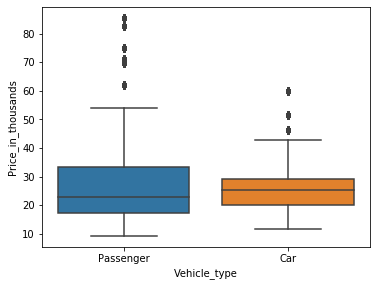

In [72]:
#Analysing the Vehicle_type column
plt.figure(figsize=(20, 15))
plt.subplot(3,3,3)
sns.boxplot(x = 'Vehicle_type', y = 'Price_in_thousands', data = df)
plt.show()


C:\Users\prith\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


[Text(0, 0.5, 'Frequency of Vehicle type'), Text(0.5, 0, 'Vehicle Type')]

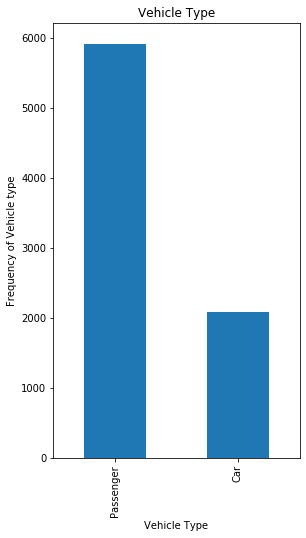

In [73]:
plt.subplot(1,3,2)
plt1 = df['Vehicle_type'].value_counts().plot('bar')
plt.title('Vehicle Type')
plt1.set(xlabel = 'Vehicle Type', ylabel='Frequency of Vehicle type')

<Figure size 1440x432 with 0 Axes>

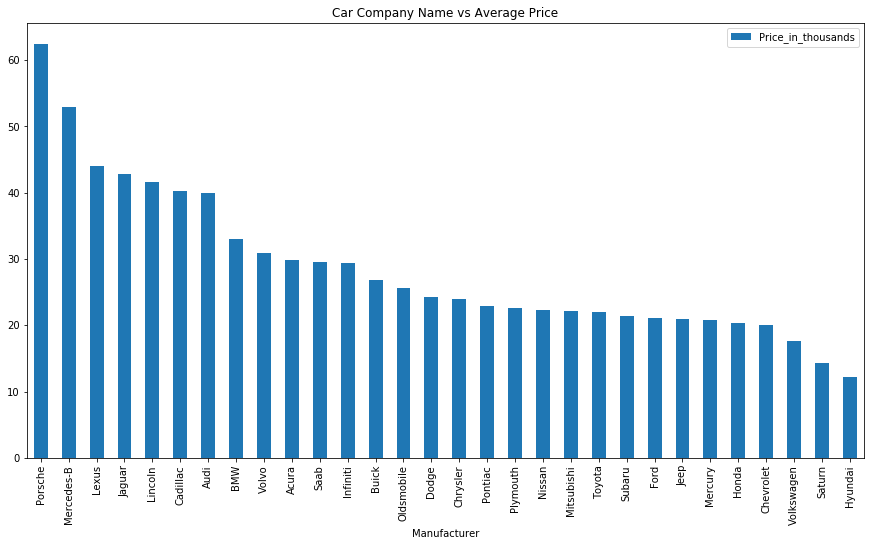

In [74]:
plt.figure(figsize=(20, 6))

df_autox = pd.DataFrame(df.groupby(['Manufacturer'])['Price_in_thousands'].mean().sort_values(ascending = False))
df_autox.plot.bar()
plt.title('Car Company Name vs Average Price')
plt.show()

### Porsche, Mercedes-B seem to have the highest average price whereas Saturn, Hyundia seem to have the lowest

<Figure size 1440x432 with 0 Axes>

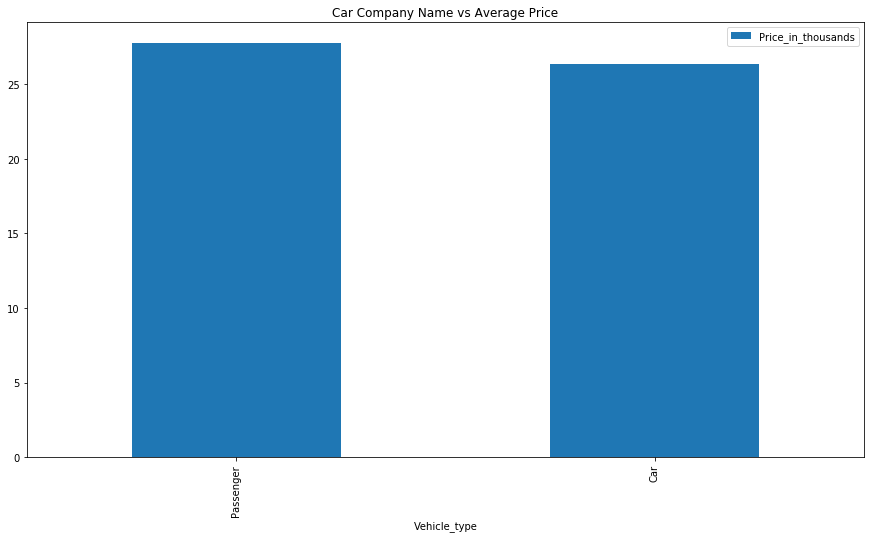

In [75]:
plt.figure(figsize=(20, 6))

df_autox = pd.DataFrame(df.groupby(['Vehicle_type'])['Price_in_thousands'].mean().sort_values(ascending = False))
df_autox.plot.bar()
plt.title('Car Company Name vs Average Price')
plt.show()

#### It is observed that there isn't much difference in the average price of Passenger Vehicle_type and Car Vehicle_type

In [76]:
#Binning the Car Companies based on avg prices of each car Company.

df['Price_in_thousands'] = df['Price_in_thousands'].astype('int')
df_temp = df.copy()
t = df_temp.groupby(['Manufacturer'])['Price_in_thousands'].mean()
df_temp = df_temp.merge(t.reset_index(), how='left',on='Manufacturer')
bins = [0,10,30,50]
label =['Budget_Friendly','Medium_Range','TopNotch_Cars']
df['Cars_Category'] = pd.cut(df_temp['Price_in_thousands_y'],bins,right=False,labels=label)
df.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor,Cars_Category
0,Acura,Integra,16.919,16.360,Passenger,21,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2012-02-02,58.280150,Medium_Range
1,Acura,TL,39.384,19.875,Passenger,28,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,2011-06-03,91.370778,Medium_Range
2,Acura,CL,14.114,18.225,Passenger,27,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,2012-01-04,77.043591,Medium_Range
3,Acura,RL,8.588,29.725,Passenger,42,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2011-03-10,91.389779,Medium_Range
4,Audi,A4,20.397,22.255,Passenger,23,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,2011-10-08,62.777639,TopNotch_Cars


#### After performing some basic visualizations, we observed that Power_perf_factor, curb_weight, horsepower, engine_size, year_release_value, fuel-efficiency are significant features with respect to Price_in_thousands variable.

In [77]:
sig_col = ['Price_in_thousands','__year_resale_value', 'Engine_size', 'Horsepower', 'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor']

In [78]:
df

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor,Cars_Category
0,Acura,Integra,16.919,16.360000,Passenger,21,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2012-02-02,58.280150,Medium_Range
1,Acura,TL,39.384,19.875000,Passenger,28,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,2011-06-03,91.370778,Medium_Range
2,Acura,CL,14.114,18.225000,Passenger,27,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,2012-01-04,77.043591,Medium_Range
3,Acura,RL,8.588,29.725000,Passenger,42,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2011-03-10,91.389779,Medium_Range
4,Audi,A4,20.397,22.255000,Passenger,23,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,2011-10-08,62.777639,TopNotch_Cars
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8002,Volvo,V40,3.545,18.072975,Passenger,24,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,2011-09-21,66.498812,TopNotch_Cars
8003,Volvo,S70,15.245,18.072975,Passenger,27,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,2012-11-24,70.654495,TopNotch_Cars
8004,Volvo,V70,17.531,18.072975,Passenger,28,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,2011-06-25,71.155978,TopNotch_Cars
8005,Volvo,C70,3.493,18.072975,Passenger,45,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,2011-04-26,101.623357,TopNotch_Cars


#### Dealing with categorical variables, Creating Dummy Variables

In [80]:
sig_cat_col = ['Manufacturer', 'Vehicle_type', 'Cars_Category']

In [81]:
# Get the dummy variables for the categorical feature and store it in a new variable - 'dummies'

dummies = pd.get_dummies(df[sig_cat_col], drop_first=True)
dummies.shape

(8007, 32)

In [82]:
df = pd.concat([df, dummies], axis = 1)

In [83]:
df

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,...,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger,Cars_Category_Medium_Range,Cars_Category_TopNotch_Cars
0,Acura,Integra,16.919,16.360000,Passenger,21,1.8,140.0,101.2,67.3,...,0,0,0,0,0,0,0,1,1,0
1,Acura,TL,39.384,19.875000,Passenger,28,3.2,225.0,108.1,70.3,...,0,0,0,0,0,0,0,1,1,0
2,Acura,CL,14.114,18.225000,Passenger,27,3.2,225.0,106.9,70.6,...,0,0,0,0,0,0,0,1,1,0
3,Acura,RL,8.588,29.725000,Passenger,42,3.5,210.0,114.6,71.4,...,0,0,0,0,0,0,0,1,1,0
4,Audi,A4,20.397,22.255000,Passenger,23,1.8,150.0,102.6,68.2,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8002,Volvo,V40,3.545,18.072975,Passenger,24,1.9,160.0,100.5,67.6,...,0,0,0,0,0,0,1,1,0,1
8003,Volvo,S70,15.245,18.072975,Passenger,27,2.4,168.0,104.9,69.3,...,0,0,0,0,0,0,1,1,0,1
8004,Volvo,V70,17.531,18.072975,Passenger,28,2.4,168.0,104.9,69.3,...,0,0,0,0,0,0,1,1,0,1
8005,Volvo,C70,3.493,18.072975,Passenger,45,2.3,236.0,104.9,71.5,...,0,0,0,0,0,0,1,1,0,1


In [84]:
#Dropping original category columns as dummies are created

df.drop( sig_cat_col, axis = 1, inplace = True)
df.shape

(8007, 46)

In [85]:
#Splitting data into train and test
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [86]:
df_train.head()

,Model,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,...,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger,Cars_Category_Medium_Range,Cars_Category_TopNotch_Cars
7696,RL,8.588,29.725000,42,3.5,210.0,114.6,71.4,196.6,3.850,...,0,0,0,0,0,0,0,1,1,0
1482,Grand Cherokee,157.040,18.810000,26,4.0,195.0,105.9,72.3,181.5,3.880,...,0,0,0,0,0,0,0,0,1,0
7844,S40,16.957,18.072975,23,1.9,160.0,100.5,67.6,176.6,2.998,...,0,0,0,0,0,0,1,1,0,1
4226,Land Cruiser,9.835,34.080000,51,4.7,230.0,112.2,76.4,192.5,5.115,...,0,0,0,0,1,0,0,0,1,0
91,Villager,20.380,14.795000,22,3.3,170.0,112.2,74.9,194.7,3.944,...,0,0,0,0,0,0,0,0,1,0


### Standardization

In [87]:
scaler = preprocessing.StandardScaler()

In [88]:
# Apply scaler() to all the columns except the 'dummy' variables
import warnings
warnings.filterwarnings("ignore")

df_train[sig_col] = scaler.fit_transform(df_train[sig_col])

In [89]:
df_train.head()

,Model,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,...,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger,Cars_Category_Medium_Range,Cars_Category_TopNotch_Cars
7696,RL,8.588,1.154617,1.055444,0.433421,0.428605,114.6,71.4,196.6,0.766062,...,0,0,0,0,0,0,0,1,1,0
1482,Grand Cherokee,157.040,0.068680,-0.062794,0.917709,0.162485,105.9,72.3,181.5,0.814268,...,0,0,0,0,0,0,0,0,1,0
7844,S40,16.957,-0.004647,-0.272463,-1.116300,-0.458463,100.5,67.6,176.6,-0.602991,...,0,0,0,0,0,0,1,1,0,1
4226,Land Cruiser,9.835,1.587897,1.684453,1.595712,0.783433,112.2,76.4,192.5,2.798752,...,0,0,0,0,1,0,0,0,1,0
91,Villager,20.380,-0.330774,-0.342353,0.239706,-0.281049,112.2,74.9,194.7,0.917107,...,0,0,0,0,0,0,0,0,1,0


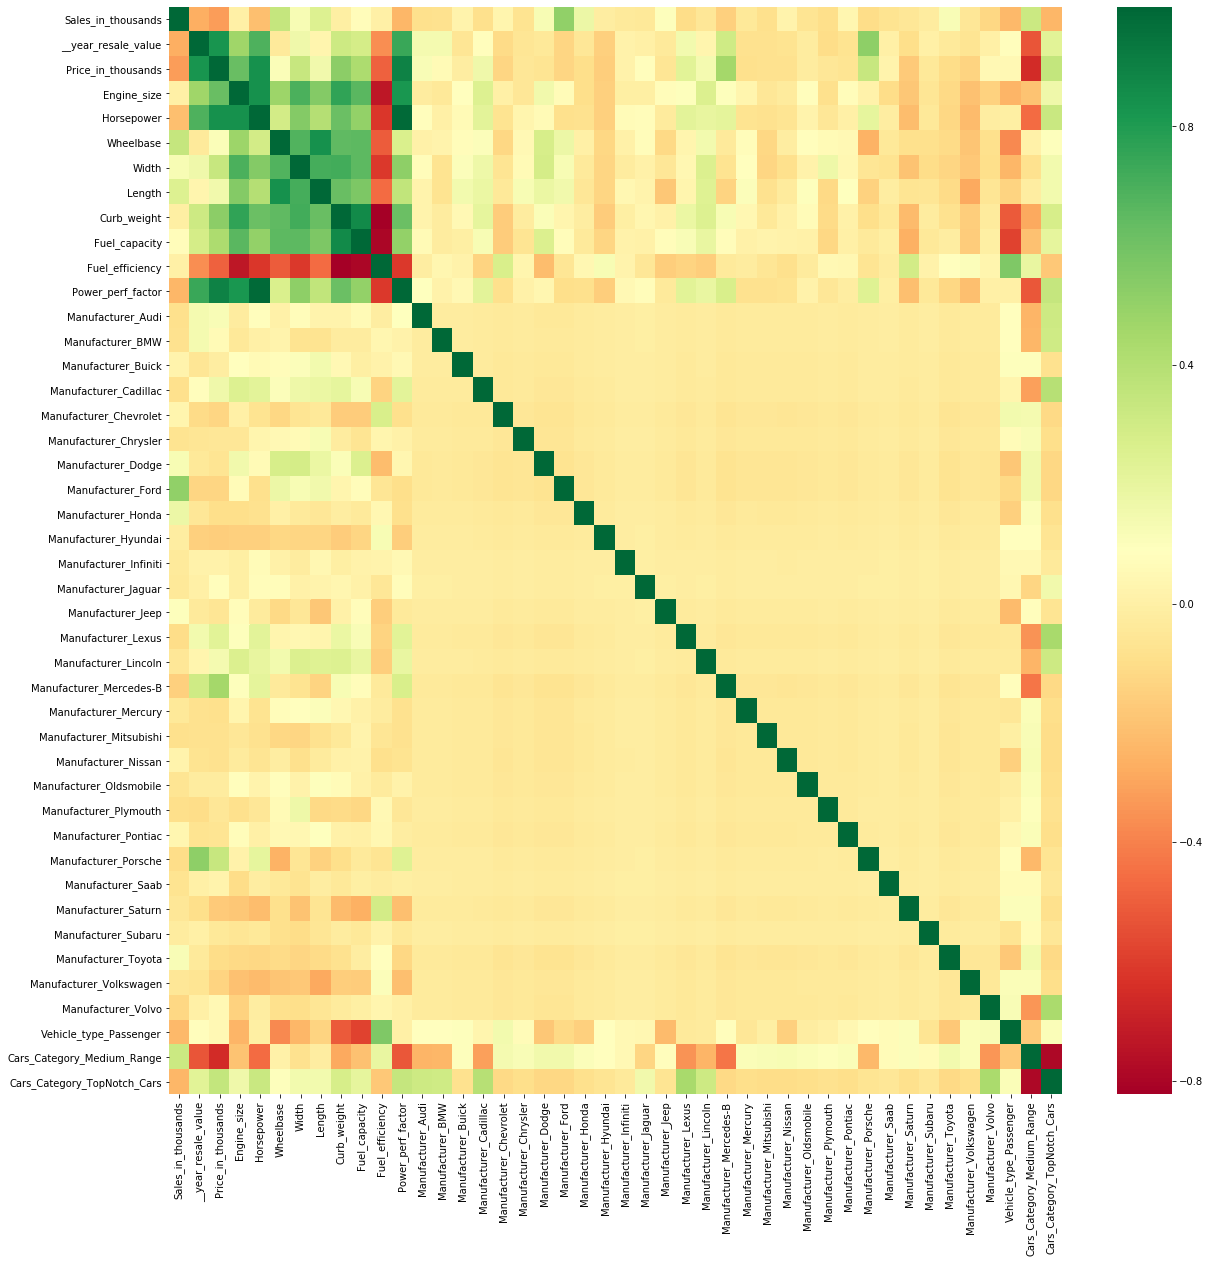

In [90]:
plt.figure(figsize = (20, 20))
sns.heatmap(df_train.corr(), cmap="RdYlGn")
plt.show()

In [91]:
y_train = df_train.pop('Price_in_thousands')
df_train.pop('Latest_Launch')
df_train.pop('Model')
X_train = df_train

In [92]:
#Bulding a linear model
X_train.columns

Index(['Sales_in_thousands', '__year_resale_value', 'Engine_size',
       'Horsepower', 'Wheelbase', 'Width', 'Length', 'Curb_weight',
       'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor',
       'Manufacturer_Audi', 'Manufacturer_BMW', 'Manufacturer_Buick',
       'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes-B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Vehicle_type_Passenger', 'Cars_Ca

In [93]:
import statsmodels.api as sm  
X_train_3 = X_train[['__year_resale_value', 'Horsepower', 'Engine_size','Power_perf_factor']]

# Add a constant
X_train_3c = sm.add_constant(X_train_3)

# Create a third fitted model
lr_3 = sm.OLS(y_train, X_train_3c).fit()

print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:     Price_in_thousands   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 4.053e+04
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:18:47   Log-Likelihood:                 1574.3
No. Observations:                5604   AIC:                            -3139.
Df Residuals:                    5599   BIC:                            -3105.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.301e-17    

### Recursive Feature Elimination

We perform this operation since we have too many independent variables

In [94]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 35)             
rfe = rfe.fit(X_train, y_train)

In [95]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Sales_in_thousands', False, 9),
 ('__year_resale_value', True, 1),
 ('Engine_size', False, 6),
 ('Horsepower', True, 1),
 ('Wheelbase', False, 5),
 ('Width', False, 3),
 ('Length', False, 8),
 ('Curb_weight', True, 1),
 ('Fuel_capacity', True, 1),
 ('Fuel_efficiency', True, 1),
 ('Power_perf_factor', True, 1),
 ('Manufacturer_Audi', False, 7),
 ('Manufacturer_BMW', True, 1),
 ('Manufacturer_Buick', True, 1),
 ('Manufacturer_Cadillac', True, 1),
 ('Manufacturer_Chevrolet', True, 1),
 ('Manufacturer_Chrysler', True, 1),
 ('Manufacturer_Dodge', True, 1),
 ('Manufacturer_Ford', True, 1),
 ('Manufacturer_Honda', True, 1),
 ('Manufacturer_Hyundai', True, 1),
 ('Manufacturer_Infiniti', True, 1),
 ('Manufacturer_Jaguar', True, 1),
 ('Manufacturer_Jeep', True, 1),
 ('Manufacturer_Lexus', False, 2),
 ('Manufacturer_Lincoln', True, 1),
 ('Manufacturer_Mercedes-B', True, 1),
 ('Manufacturer_Mercury', True, 1),
 ('Manufacturer_Mitsubishi', True, 1),
 ('Manufacturer_Nissan', True, 1),
 ('Manufact

In [96]:
# Selecting the variables which are in support

col_sup = X_train.columns[rfe.support_]
col_sup

Index(['__year_resale_value', 'Horsepower', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency', 'Power_perf_factor', 'Manufacturer_BMW',
       'Manufacturer_Buick', 'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lincoln',
       'Manufacturer_Mercedes-B', 'Manufacturer_Mercury',
       'Manufacturer_Mitsubishi', 'Manufacturer_Nissan',
       'Manufacturer_Oldsmobile', 'Manufacturer_Plymouth',
       'Manufacturer_Pontiac', 'Manufacturer_Porsche', 'Manufacturer_Saab',
       'Manufacturer_Saturn', 'Manufacturer_Subaru', 'Manufacturer_Toyota',
       'Manufacturer_Volkswagen', 'Vehicle_type_Passenger',
       'Cars_Category_Medium_Range', 'Cars_Category_TopNotch_Cars'],
      dtype='object')

In [97]:
# Creating X_train dataframe with RFE selected variables

X_train_rfe = X_train[col_sup]

In [98]:
# Adding a constant variable and Build a first fitted model
import statsmodels.api as sm  
X_train_rfec = sm.add_constant(X_train_rfe)
lm_rfe = sm.OLS(y_train,X_train_rfec).fit()

#Summary of linear model
print(lm_rfe.summary())

                            OLS Regression Results                            
Dep. Variable:     Price_in_thousands   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     7222.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:18:48   Log-Likelihood:                 2720.4
No. Observations:                5604   AIC:                            -5371.
Df Residuals:                    5569   BIC:                            -5139.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

#### Looking at the p-value of some of the features it is understood that some of the features with high p-values(>0.05) can be eliminated 

### Checking for multicolinearity using VIF: 

In [99]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,Power_perf_factor,143.99
1,Horsepower,118.82
33,Cars_Category_Medium_Range,41.25
2,Curb_weight,8.64
4,Fuel_efficiency,6.70
3,Fuel_capacity,5.84
0,__year_resale_value,4.96
34,Cars_Category_TopNotch_Cars,4.13
11,Manufacturer_Dodge,4.03
12,Manufacturer_Ford,3.79


### Dropping columns to finetune the model


In [100]:
# Dropping highly correlated variables and insignificant variables
X_train_rfe1 = X_train_rfe[['__year_resale_value','Horsepower','Curb_weight','Fuel_capacity','Fuel_efficiency','Power_perf_factor']]
#X_train_rfe1 = X_train_rfe.drop(['Cars_Category_Medium_Range','Power_perf_factor'], 1,)

# Adding a constant variable and Build a second fitted model

X_train_rfe1c = sm.add_constant(X_train_rfe1)
lm_rfe1 = sm.OLS(y_train, X_train_rfe1c).fit()

#Summary of linear model
print(lm_rfe1.summary())

                            OLS Regression Results                            
Dep. Variable:     Price_in_thousands   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 2.654e+04
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:18:49   Log-Likelihood:                 1526.7
No. Observations:                5604   AIC:                            -3039.
Df Residuals:                    5597   BIC:                            -2993.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.301e-17    

In [101]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe1.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe1.values, i) for i in range(X_train_rfe1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,Power_perf_factor,91.54
1,Horsepower,76.56
2,Curb_weight,5.78
3,Fuel_capacity,4.57
4,Fuel_efficiency,3.75
0,__year_resale_value,3.21


In [136]:
# Dropping highly correlated variables and insignificant variables
X_train_rfe2 = X_train_rfe1[['__year_resale_value','Power_perf_factor','Curb_weight','Fuel_capacity','Fuel_efficiency',]]

#X_train_rfe2 = X_train_rfe1.drop([], 1,)

# Adding a constant variable and Build a second fitted model

X_train_rfe8c = sm.add_constant(X_train_rfe2)
lm_rfe8 = sm.OLS(y_train, X_train_rfe8c).fit()

#Summary of linear model
print(lm_rfe8.summary())

                            OLS Regression Results                            
Dep. Variable:     Price_in_thousands   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     7494.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:40:22   Log-Likelihood:                -2234.5
No. Observations:                5604   AIC:                             4481.
Df Residuals:                    5598   BIC:                             4521.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.301e-17    

In [103]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe2.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe2.values, i) for i in range(X_train_rfe2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Curb_weight,5.67
3,Fuel_capacity,4.57
1,Power_perf_factor,3.73
4,Fuel_efficiency,3.70
0,__year_resale_value,2.45


In [137]:
# Dropping highly correlated variables and insignificant variables
X_train_rfe3 = X_train_rfe1[['__year_resale_value','Horsepower','Curb_weight','Fuel_capacity','Fuel_efficiency',]]

#X_train_rfe2 = X_train_rfe1.drop([], 1,)

# Adding a constant variable and Build a second fitted model

X_train_rfe10c = sm.add_constant(X_train_rfe3)
lm_rfe10 = sm.OLS(y_train, X_train_rfe10c).fit()

#Summary of linear model
print(lm_rfe10.summary())

                            OLS Regression Results                            
Dep. Variable:     Price_in_thousands   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     5487.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:40:26   Log-Likelihood:                -2978.1
No. Observations:                5604   AIC:                             5968.
Df Residuals:                    5598   BIC:                             6008.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.301e-17    

In [105]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe3.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe3.values, i) for i in range(X_train_rfe3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Curb_weight,5.52
3,Fuel_capacity,4.56
4,Fuel_efficiency,3.73
1,Horsepower,3.12
0,__year_resale_value,2.04


#### Now the VIFs and p-values both are within an acceptable range. So we can go ahead and make our predictions using model lm_rfe8 and lm_rfe10

#### Model 1


In [106]:
#Model 1
# Predicting the price of training set.
y_train_price = lm_rfe10.predict(X_train_rfe10c)

Text(0.5, 0, 'Errors')

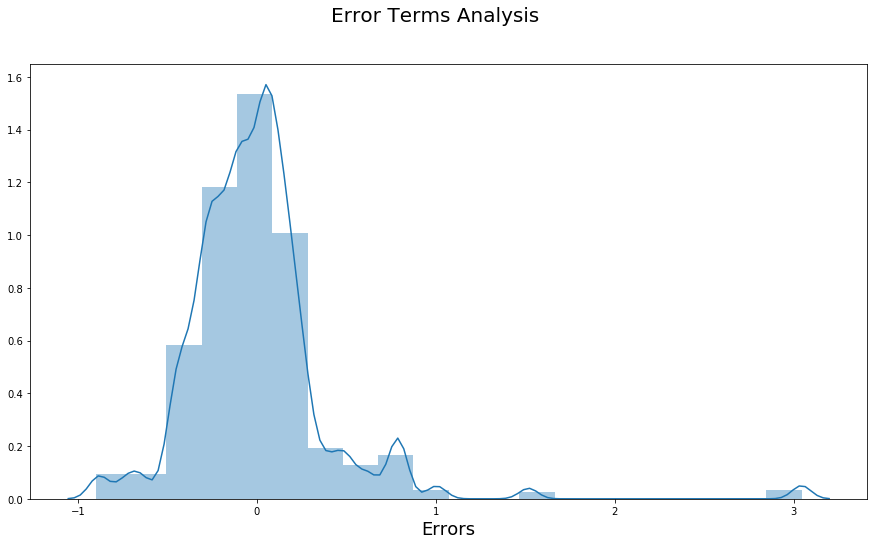

In [107]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms Analysis', fontsize = 20)                   
plt.xlabel('Errors', fontsize = 18)

In [108]:
#Apply scaling 
import warnings
warnings.filterwarnings("ignore")

df_test[sig_col] = scaler.transform(df_test[sig_col])
df_test.shape

(2403, 46)

In [127]:
#y_test = df_test.pop('Price_in_thousands')
#df_test.pop('Latest_Launch')
#df_test.pop('Model')

X_test = df_test

In [139]:
# Adding constant
X_test_1 = sm.add_constant(X_test)

X_test_new = X_test_1[X_train_rfe10c.columns]

In [111]:
# Making predictions using the final model
y_pred = lm_rfe10.predict(X_test_new)

In [112]:
X_test_new

,const,__year_resale_value,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency
1436,1.0,-0.506872,0.251192,0.203657,-0.291959,0.259618
732,1.0,-0.272572,-0.281049,0.992630,0.540740,-0.683945
5235,1.0,0.542751,0.960846,2.305443,2.102049,-1.863399
310,1.0,-0.004647,-0.316532,-0.265549,-0.005719,0.259618
7676,1.0,-0.850114,-0.777807,-1.274663,-0.734329,-0.212164
...,...,...,...,...,...,...
4223,1.0,-0.004647,0.144744,0.619837,0.774936,-0.448054
330,1.0,0.756655,1.581794,0.754814,0.280521,-0.448054
2228,1.0,-0.437229,0.251192,0.126528,-0.239915,0.495508
6530,1.0,2.321141,0.623760,0.722676,0.826980,0.259618


### Model Evaluation

Text(0, 0.5, 'y_pred')

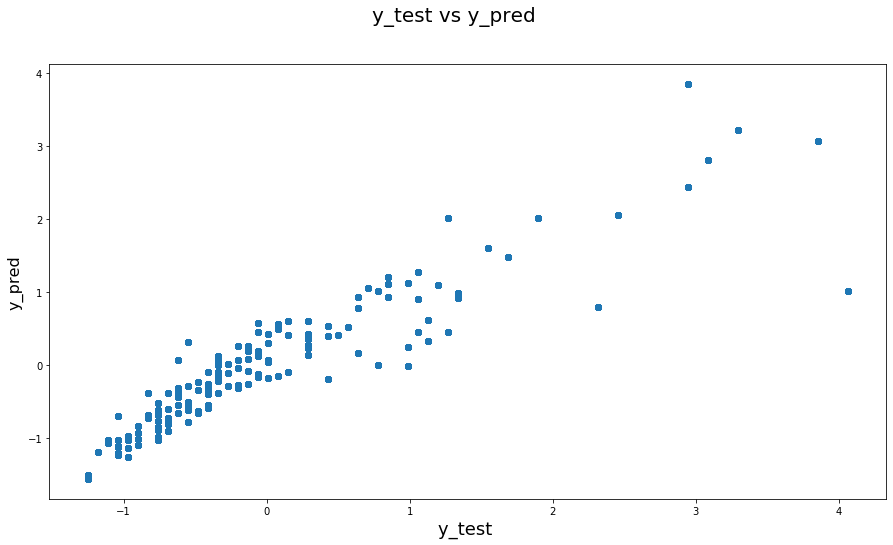

In [113]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)   
plt.xlabel('y_test ', fontsize=18)                       
plt.ylabel('y_pred', fontsize=16)    

In [114]:
r2_score(y_test, y_pred)

0.8214442931569719

#### Model 2

In [115]:
# Predicting the price of training set.
y_train_price2 = lm_rfe8.predict(X_train_rfe8c)

Text(0.5, 0, 'Errors')

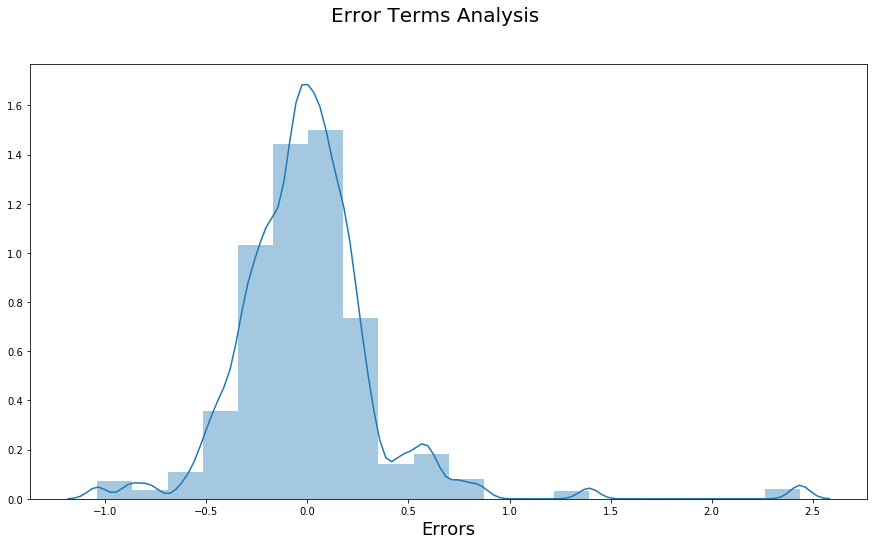

In [116]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price2), bins = 20)
fig.suptitle('Error Terms Analysis', fontsize = 20)                   
plt.xlabel('Errors', fontsize = 18)

In [117]:
X_test_2 = X_test_1[X_train_rfe8c.columns]

In [118]:
# Making predictions using the final model
y_pred2 = lm_rfe8.predict(X_test_2)

Text(0, 0.5, 'y_pred2')

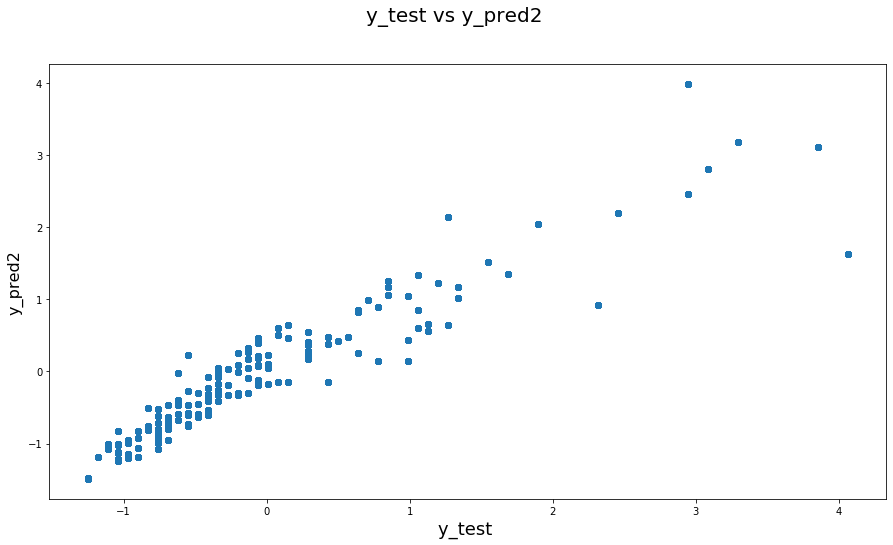

In [119]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred2)
fig.suptitle('y_test vs y_pred2', fontsize=20)   
plt.xlabel('y_test ', fontsize=18)                       
plt.ylabel('y_pred2', fontsize=16)   

In [120]:
r2_score(y_test, y_pred2)

0.8602477592502882

#### The adjusted R-square on training is 87 and on test is 83 which is pretty close.

In [121]:
import pickle

In [122]:
pickle.dump(lm_rfe10, open('model.pkl','wb'))

In [123]:
model = pickle.load(open('model.pkl','rb'))

In [124]:
print(model.predict([[300, 4, 26, 17, 30, 1]]))

[16.01781158]
